In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix , classification_report

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:

import pathlib
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/potato",  # Path to dataset folder
    seed=123,                          # Ensures shuffling consistency
    shuffle=True,                       # Shuffles data before creating batches
    image_size=(IMAGE_SIZE, IMAGE_SIZE), # Resizes images to (IMAGE_SIZE, IMAGE_SIZE)
    batch_size=BATCH_SIZE                # Number of images per batch
)


Found 2152 files belonging to 3 classes.


In [4]:
len(dataset) # means that contain 68 batches each carry 32 images

68

In [5]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

let visualize images from each directory


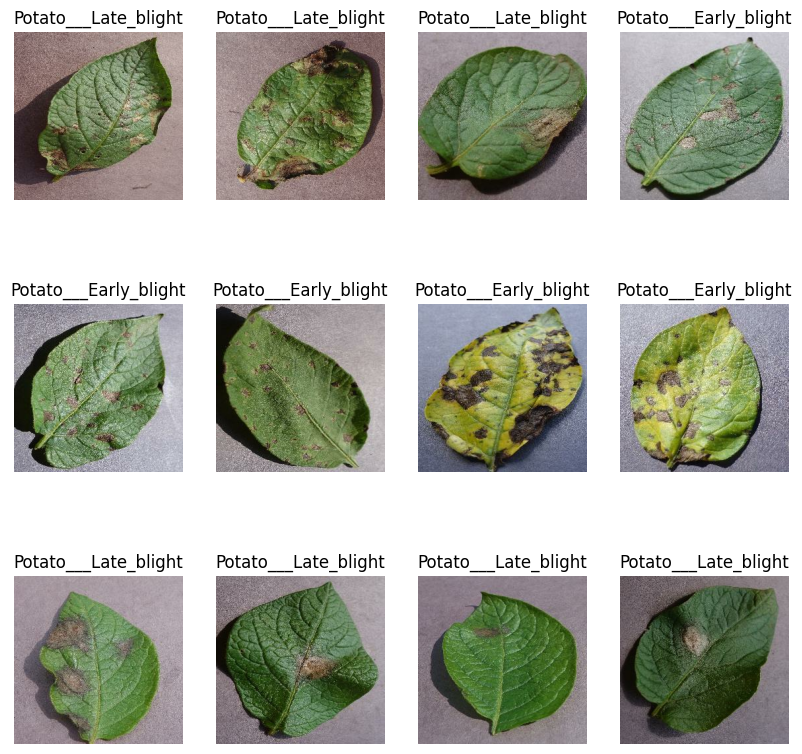

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1): #image batch variable for images | labels tach variable to get labels i.e class names
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[labels_batch[i]])
        plt.axis("off")

In [7]:
for image_batch,labels_batch in dataset.take(1):
   print(image_batch.shape)
   print(labels_batch.numpy())
#0,1,2 are the classes of leafs

(32, 256, 256, 3)
[0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 2 0 0 0 0 1 1 0]


#seggrigate our dataset<br>
80% -> training <br> 20 % = 10% -> validation , 10% ->testing

In [8]:
#Training dataset
train_size = int(len(dataset)*0.8)
train_ds = dataset.take(train_size)

In [9]:
#Testing dataset


test_ds = dataset.skip(train_size)

#validation set
test_size = int(len(dataset)*0.1)

val_ds = test_ds.take(test_size)

#actual test
evl_ds = test_ds.skip(test_size)




###printing all sets

In [10]:
print(f"Train batches: {train_ds.cardinality().numpy()}")
print(f"Validation batches: {val_ds.cardinality().numpy()}")
print(f"Test batches: {evl_ds.cardinality().numpy()}")

Train batches: 54
Validation batches: 6
Test batches: 8


In [11]:
#fucntion for above
def get_dataset_partition(ds,train_split = 0.8,test_split = 0.1,val_split= 0.1,shuffle=True,shuffle_size=10000):
  assert (train_split + test_split + val_split) == 1

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size,seed=12)

  train_size = int(ds_size*train_split)
  val_size = int(ds_size*test_split)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)

  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds,val_ds,test_ds


In [12]:
train_ds,val_ds,test_ds = get_dataset_partition(dataset)


In [13]:
len(train_ds)

54

In [14]:
len(test_ds)

8

In [15]:
len(val_ds)

6

In [16]:
train_ds = train_ds.cache().shuffle(999).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(999).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(999).prefetch(buffer_size=tf.data.AUTOTUNE)

Resize and rescale layer

In [17]:
resize_and_rescale = keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

Data agumentation

In [18]:
data_agumentation = keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

building our CNN network

In [19]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = keras.models.Sequential([
    resize_and_rescale,
    data_agumentation,
    layers.Conv2D(filters = 32 , kernel_size=(3,3) , input_shape = input_shape, activation ='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters = 64 ,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters = 64 ,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters = 64 ,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters = 64 ,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters = 64 ,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')

])
model.build(input_shape=input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(
    optimizer = 'adam',
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)



In [22]:
from re import VERBOSE
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1

)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 239s 199ms/step - accuracy: 0.4170 - loss: 0.9745 - val_accuracy: 0.4896 - val_loss: 0.8738
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step - accuracy: 0.5876 - loss: 0.8274 - val_accuracy: 0.7240 - val_loss: 0.6601
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.7849 - loss: 0.5525 - val_accuracy: 0.8594 - val_loss: 0.3618
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8532 - loss: 0.3626 - val_accuracy: 0.8698 - val_loss: 0.2729
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9094 - loss: 0.2469 - val_accuracy: 0.8802 - val_loss: 0.3767
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8972 - loss: 0.2702 - val_accuracy: 0.8333 - val_loss: 0.4217
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.8856 - loss: 0.2918 - val_accuracy: 0.9115 - val_loss: 0.3029
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9274 - loss: 0.1891 - val_accuracy: 0.7969

In [23]:
score = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9661 - loss: 0.1531


In [24]:
score

[0.13298113644123077, 0.96875]

In [25]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [26]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

let visualize accuracy and losses

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']



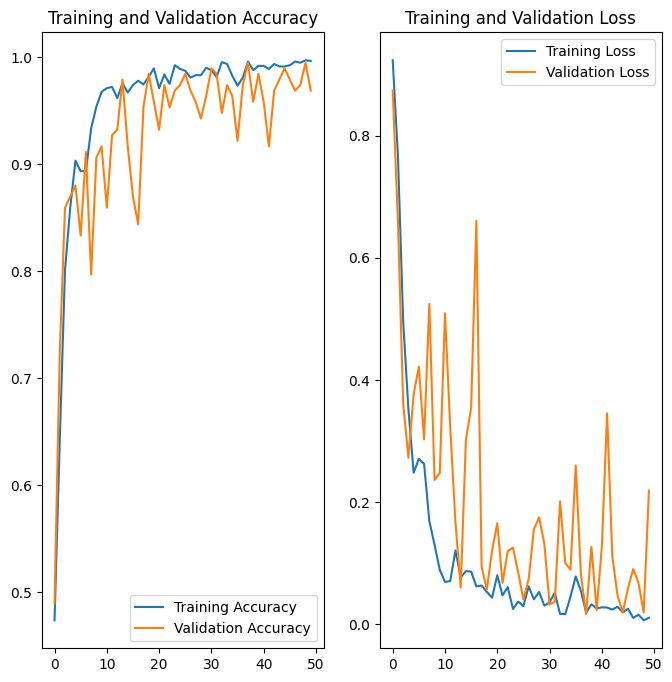

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

actual label Potato___Late_blight
first image AxesImage(shape=(256, 256, 3))
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
predicted label Potato___Late_blight


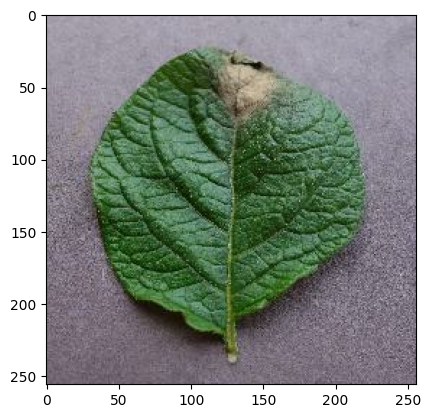

In [29]:
for image_batch,labels_batch in test_ds.take(1):

  first_image = image_batch[3].numpy().astype('uint8')
  first_label = labels_batch[3].numpy()

  print(f"actual label {class_name[first_label]}")
  print(f"first image {plt.imshow(first_image)}")

  batch_pred = model.predict(image_batch)
  print(f"predicted label {class_name[np.argmax(batch_pred[3])]}")

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


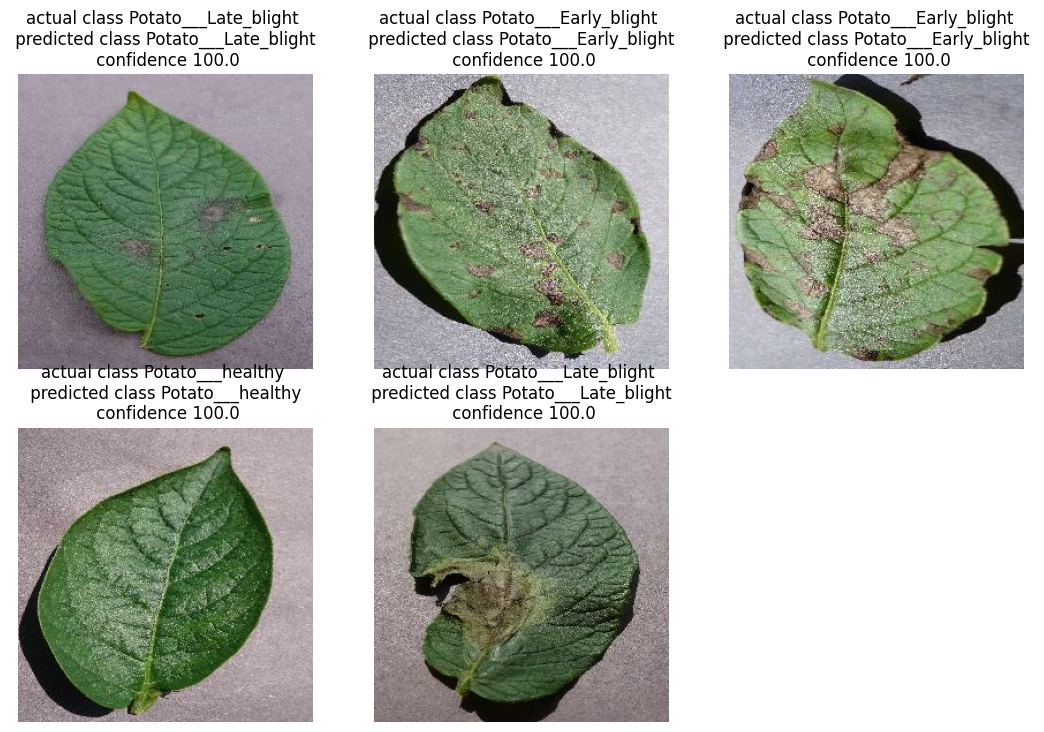

In [31]:
plt.figure(figsize=(13, 13))
for images,labels in test_ds.take(1):
  for i in range(5):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())

    actual_class = class_name[labels[i]]

    plt.title(f"actual class {actual_class} \n predicted class {predicted_class} \n confidence {confidence}")
    plt.axis('off')

In [39]:
import numpy as np
from sklearn.metrics import classification_report

# Convert test dataset to numpy arrays (X_test, y_test)
y_true = []
for images, labels in test_ds:  # Extract labels
    y_true.extend(labels.numpy())  # Convert tensor to numpy list

y_true = np.array(y_true)  # Convert to numpy array
print(f"True labels shape: {y_true.shape}")

# Ensure predictions are same length
y_pred_classes = np.array(y_pred_classes[:len(y_true)])  # Trim if needed
print(f"Predicted labels shape: {y_pred_classes.shape}")

# Now, generate classification report
print(f'Classification Report:\n{classification_report(y_true, y_pred_classes)}')



True labels shape: (256,)
Predicted labels shape: (256,)
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.46      0.45       110
           1       0.50      0.48      0.49       128
           2       0.22      0.22      0.22        18

    accuracy                           0.45       256
   macro avg       0.39      0.39      0.39       256
weighted avg       0.45      0.45      0.45       256



In [32]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

model.save("../potatoes.h5")

FileNotFoundError: [Errno 2] No such file or directory: '../models'